In [414]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [415]:
from datetime import date
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import linear_model, tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import ensemble
from sklearn.decomposition import PCA

In [416]:
def get_names(dataframe):
    cols = dataframe.columns
    s = set()
    for col in cols:
        s.add(col[:col.find("_")])
    return list(s)

In [417]:
data = pd.read_csv("./data.csv")

In [418]:
data.reindex_axis(sorted(data.columns), axis=1)
data.set_index("Date", inplace=True)
data.index = pd.to_datetime(data.index)
data.sort_index(inplace=True)

In [425]:
all_stocks = get_names(data)
#use_stocks = ["GOOGL", "AAPL", "NFLX", "AMZN", "QCOM", "SBUX"]
use_stocks = ["SPY", "USB", "JPM", "MSFT", "CAT"]

In [426]:
def select_stocks(dataframe, stocks, suffix = "_Cls%"):
    transformed = list(map(lambda x : x + suffix, stocks))
    selected = dataframe[transformed]
    selected.columns = stocks
    return selected

In [427]:
selected = select_stocks(data, use_stocks)
selected_all = select_stocks(data, all_stocks)

In [428]:
dataset = selected.tail(1100)

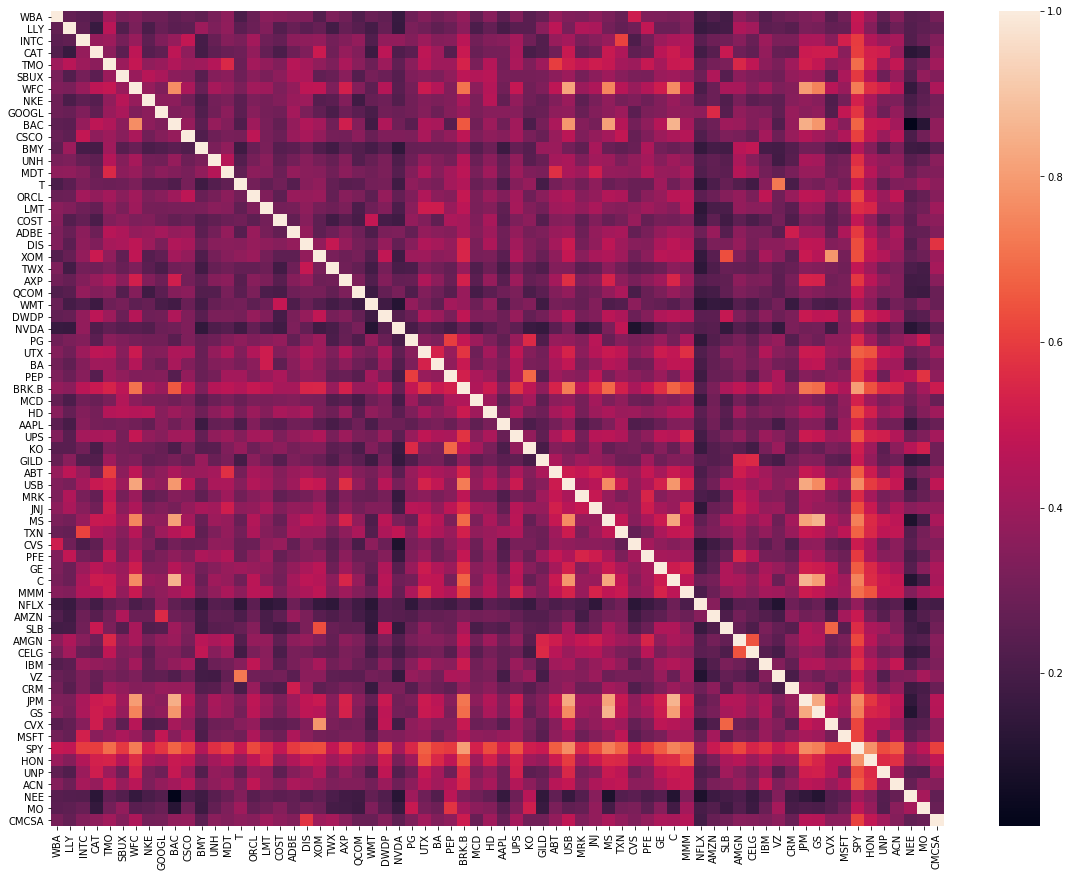

In [429]:
corr = selected_all.tail(1100).corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [549]:
dataset.corr()

,SPY,USB,JPM,MSFT,CAT
SPY,1.000000,0.765861,0.759878,0.614661,0.601578
USB,0.765861,1.000000,0.829854,0.417971,0.497563
JPM,0.759878,0.829854,1.000000,0.422293,0.503763
MSFT,0.614661,0.417971,0.422293,1.000000,0.356486
CAT,0.601578,0.497563,0.503763,0.356486,1.000000


In [550]:
n_names = len(dataset.columns)
raw_dataset = dataset.tail(1000)
raw_outputs = raw_dataset.as_matrix()
feature_ma2 = dataset.rolling(window = 2, center=False).mean().tail(1000)
feature_ma3 = dataset.rolling(window = 3, center=False).mean().tail(1000)
feature_ma5 = dataset.rolling(window = 5, center=False).mean().tail(1000)
feature_ma10 = dataset.rolling(window = 10, center=False).mean().tail(1000)
feature_ma30 = dataset.rolling(window = 30, center=False).mean().tail(1000)

feature_mstd30 = dataset.rolling(window = 30, center=False).mean().tail(1000)

features = np.hstack([feature_ma2, feature_ma3, feature_ma5, feature_ma10, feature_ma30])

1 - linear regression model =)

In [599]:
#features_lin = np.vstack([feature_ma2["SPY"], feature_ma3["SPY"], feature_ma5["SPY"], feature_ma10["SPY"], feature_ma30["SPY"]]).reshape((1000,-1))
features_lin = features
X_train_lin, X_test_lin, y_train_lin, y_test_lin=train_test_split(features_lin, raw_outputs, test_size = 0.2, shuffle=False)

In [600]:
lin_model = linear_model.LinearRegression(fit_intercept=True)

In [601]:
lin_model.fit(X_train_lin, y_train_lin)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [602]:
y_train_prediction_lin = lin_model.predict(X_train_lin)

train dataset scores

In [603]:
print(r2_score(y_train_lin, y_train_prediction_lin, multioutput = "raw_values"))
print(mean_squared_error(y_train_lin, y_train_prediction_lin, multioutput = "raw_values"))

[ 0.53519212  0.50873436  0.50988328  0.51256457  0.49582926]
[ 0.3166873   0.64740614  0.9021358   1.03702051  1.13767486]


In [604]:
y_test_prediction_lin = lin_model.predict(X_test_lin)

In [605]:
print(r2_score(y_test_lin, y_test_prediction_lin, multioutput = "raw_values"))
print(mean_squared_error(y_test_lin, y_test_prediction_lin, multioutput = "raw_values"))

[ 0.39069642  0.46365834  0.48275756  0.46515445  0.47809016]
[ 0.11213232  0.37483548  0.48441264  0.44040342  0.92611484]


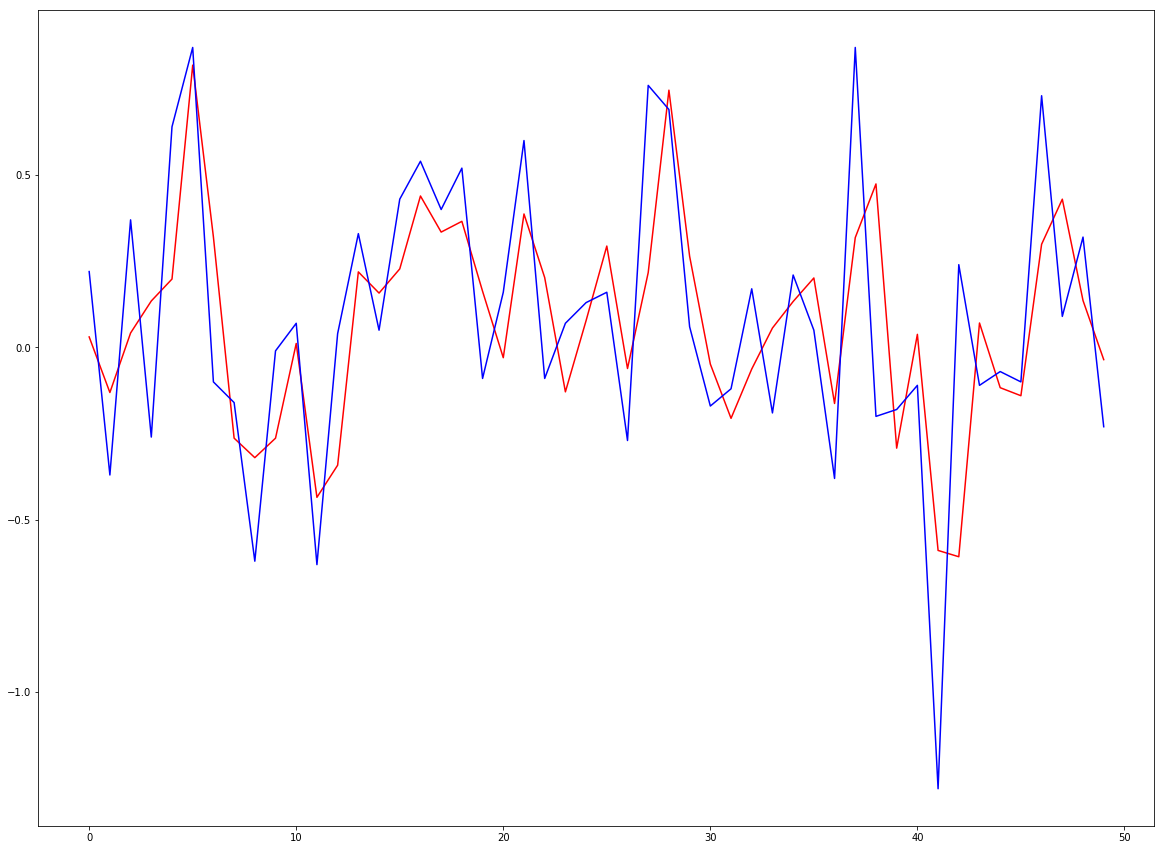

In [607]:
plt.subplots(figsize=(20,15))
plt.plot(y_test_prediction_lin[:50, 0], 'r')
plt.plot(y_test_lin[:50,0], 'b')

NN

In [532]:
import tensorflow as tf

In [608]:
current_name = 'SPY'
current_outputs = raw_dataset[current_name].as_matrix()
nn_ma2 = dataset[current_name].rolling(window = 2, center=False).mean().tail(1000).as_matrix()
nn_ma3 = dataset[current_name].rolling(window = 3, center=False).mean().tail(1000).as_matrix()
nn_ma5 = dataset[current_name].rolling(window = 5, center=False).mean().tail(1000).as_matrix()
nn_ma10 = dataset[current_name].rolling(window = 10, center=False).mean().tail(1000).as_matrix()
nn_ma20 = dataset[current_name].rolling(window = 20, center=False).mean().tail(1000).as_matrix()
nn_features = np.vstack([nn_ma2, nn_ma3, nn_ma5, nn_ma10, nn_ma20]).reshape((1000,-1))

nn_ma2_train, nn_ma2_test, nn_ma3_train, nn_ma3_test, nn_ma5_train, nn_ma5_test, ytrainNN, ytestNN = train_test_split(nn_ma2, nn_ma3, nn_ma5, current_outputs, test_size = 0.2, shuffle=False)

In [534]:
def get_input_fn(X, X_labels, y = None, num_epochs=None, shuffle=False):
    return tf.estimator.inputs.numpy_input_fn(
      x = dict(zip(X_labels, X)),
      y = y,
      num_epochs=num_epochs,
      shuffle=shuffle)

In [535]:
nn_feature_ma2  = tf.contrib.layers.real_valued_column("ma2")
nn_feature_ma3  = tf.contrib.layers.real_valued_column("ma3")
nn_feature_ma5  = tf.contrib.layers.real_valued_column("ma5")
nn_feature_ma10 = tf.contrib.layers.real_valued_column("ma10")
nn_feature_ma20 = tf.contrib.layers.real_valued_column("ma20")
nn_features_list = [
    nn_feature_ma2
    ,nn_feature_ma3
    ,nn_feature_ma5
    #,nn_feature_ma10
    #,nn_feature_ma20
]
nn_feature_labels = ["ma2", "ma3", "ma5"]

In [578]:
model_basic_config = tf.estimator.RunConfig()
model_basic_config.replace(log_step_count_steps = 1000)
model_basic = tf.estimator.DNNRegressor(
    feature_columns=nn_features_list
    ,hidden_units=[1024, 512, 256]
    ,config = model_basic_config)

INFO:tensorflow:Using config: {'_model_dir': 'D:\\Temp\\SYSTEM\\tmpgjbyxy_g', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}


In [579]:
model_wtf_config = tf.estimator.RunConfig()
model_wtf_config.replace(log_step_count_steps = 1000)
model_wtf = tf.estimator.DNNLinearCombinedRegressor(
    linear_feature_columns = nn_features_list
    ,dnn_feature_columns = nn_features_list
    
    ,linear_optimizer=tf.train.RMSPropOptimizer(0.01)
    
    ,dnn_hidden_units = [5, 20, 5]
    ,dnn_dropout = 0.05
    ,config = model_wtf_config
)

INFO:tensorflow:Using config: {'_model_dir': 'D:\\Temp\\SYSTEM\\tmphvhpw5_w', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}


In [580]:
train_input = get_input_fn( [nn_ma2_train, nn_ma3_train, nn_ma5_train] ,nn_feature_labels , y = ytrainNN)
test_input = get_input_fn( [nn_ma2_test, nn_ma3_test, nn_ma5_test] ,nn_feature_labels , y = ytestNN, num_epochs=1)

In [581]:
model.train(train_input, steps=2000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from D:\Temp\SYSTEM\tmpz2mppnw_\model.ckpt-47000
INFO:tensorflow:Saving checkpoints for 47001 into D:\Temp\SYSTEM\tmpz2mppnw_\model.ckpt.
INFO:tensorflow:loss = 23.9007, step = 47001
INFO:tensorflow:global_step/sec: 1534.36
INFO:tensorflow:loss = 23.9007, step = 47101 (0.067 sec)
INFO:tensorflow:global_step/sec: 1511.13
INFO:tensorflow:loss = 23.9007, step = 47201 (0.066 sec)
INFO:tensorflow:global_step/sec: 1846.93
INFO:tensorflow:loss = 23.9007, step = 47301 (0.054 sec)
INFO:tensorflow:global_step/sec: 1797
INFO:tensorflow:loss = 23.9007, step = 47401 (0.056 sec)
INFO:tensorflow:global_step/sec: 1846.92
INFO:tensorflow:loss = 23.9007, step = 47501 (0.055 sec)
INFO:tensorflow:global_step/sec: 1864.21
INFO:tensorflow:loss = 23.9007, step = 47601 (0.053 sec)
INFO:tensorflow:global_step/sec: 1676.2
INFO:tensorflow:loss = 23.9007, step = 47701 (0.060 sec)
INFO:tensorflow:global_step/sec: 1734.5
INFO:tensorflo

In [540]:
model_wtf.train(train_input, steps=6000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into D:\Temp\SYSTEM\tmp4_dawypg\model.ckpt.
INFO:tensorflow:loss = 49.8258, step = 1
INFO:tensorflow:global_step/sec: 1055.4
INFO:tensorflow:loss = 24.8522, step = 101 (0.096 sec)
INFO:tensorflow:global_step/sec: 1114.33
INFO:tensorflow:loss = 24.2579, step = 201 (0.090 sec)
INFO:tensorflow:global_step/sec: 1061.01
INFO:tensorflow:loss = 23.875, step = 301 (0.094 sec)
INFO:tensorflow:global_step/sec: 997.343
INFO:tensorflow:loss = 24.1711, step = 401 (0.102 sec)
INFO:tensorflow:global_step/sec: 973.016
INFO:tensorflow:loss = 23.5071, step = 501 (0.103 sec)
INFO:tensorflow:global_step/sec: 1007.41
INFO:tensorflow:loss = 23.8178, step = 601 (0.098 sec)
INFO:tensorflow:global_step/sec: 1055.39
INFO:tensorflow:loss = 24.0327, step = 701 (0.093 sec)
INFO:tensorflow:global_step/sec: 1120.61
INFO:tensorflow:loss = 24.3245, step = 801 (0.090 sec)
INFO:tensorflow:global_step/sec: 1095.98
INFO:tensorflow:loss = 

In [541]:
pred = model.predict( input_fn = test_input)
predictions_arr = np.array([p["predictions"] for p in pred])
predictions_arr = predictions_arr.reshape((-1))

INFO:tensorflow:Restoring parameters from D:\Temp\SYSTEM\tmpz2mppnw_\model.ckpt-36000


In [542]:
wtf_pred = model_wtf.predict( input_fn = test_input)
wtf_predictions_arr = np.array([p["predictions"] for p in wtf_pred])
wtf_predictions_arr = wtf_predictions_arr.reshape((-1))

INFO:tensorflow:Restoring parameters from D:\Temp\SYSTEM\tmp4_dawypg\model.ckpt-6000


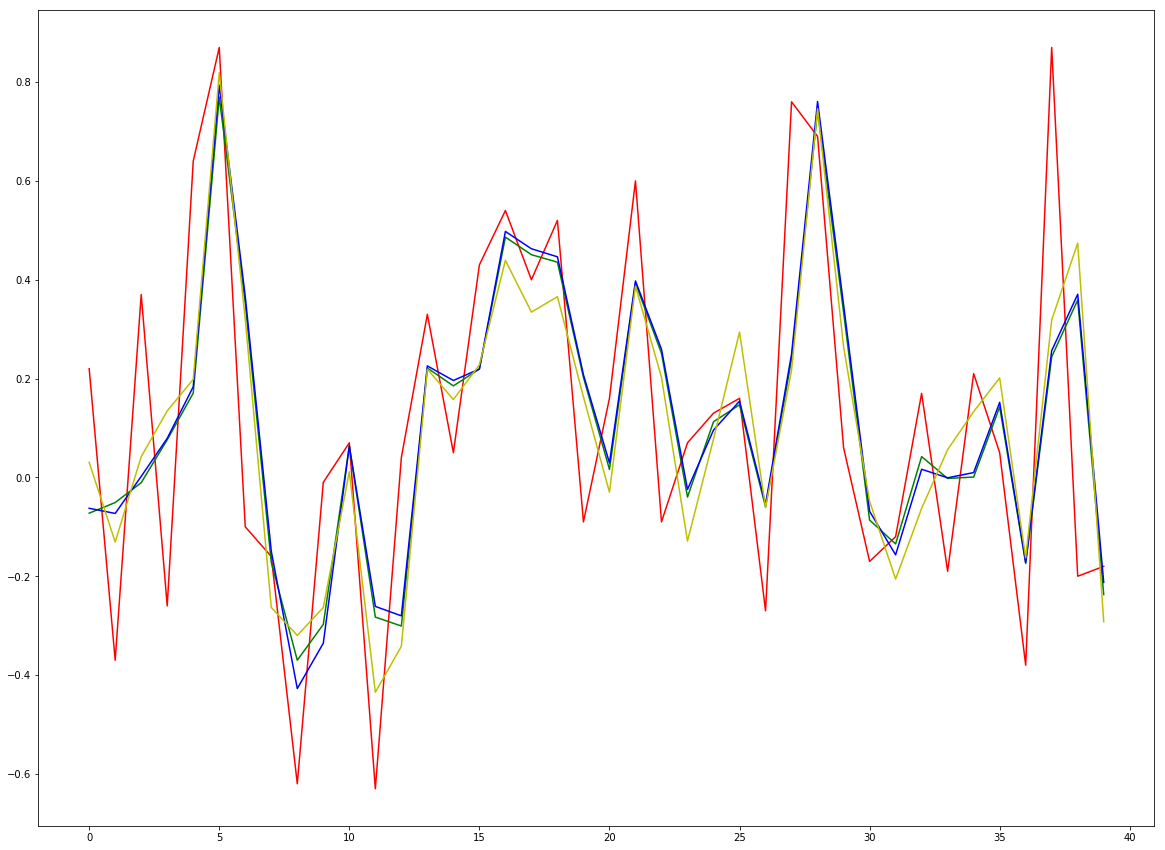

In [548]:
plt.subplots(figsize=(20,15))
plt.plot(ytestNN[:40], 'r')
plt.plot(predictions_arr[:40], 'g')
plt.plot(wtf_predictions_arr[:40], 'b')
plt.plot(y_test_prediction_lin[:40, 0], 'y')

In [528]:
print(r2_score(ytestNN, predictions_arr, multioutput = "raw_values"))
print(mean_squared_error(ytestNN, predictions_arr, multioutput = "raw_values"))
print("#"*20)
print(r2_score(ytestNN, wtf_predictions_arr, multioutput = "raw_values"))
print(mean_squared_error(ytestNN, wtf_predictions_arr, multioutput = "raw_values"))

[ 0.43804093]
[ 0.10341934]
####################
[ 0.43916694]
[ 0.10321211]


In [529]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa as tsa

[ 0.41372778]
[ 0.10789377]


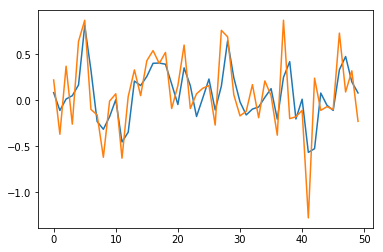

In [530]:
rlm_mnodel = sm.RLM( y_train_lin[:,0], X_train_lin , M=sm.robust.norms.AndrewWave())
rlm_result = rlm_mnodel.fit(conv = 'sresid')
pred = rlm_result.predict(X_test_lin)
print(r2_score(y_test_lin[:,0], pred, multioutput = "raw_values"))
print(mean_squared_error(y_test_lin[:,0], pred, multioutput = "raw_values"))
plt.plot(pred[:50])
plt.plot(y_test_lin[:50,0])

In [512]:
tf.estimator.DNNLinearCombinedRegressor?